# Effects of ECT on slow oscillations and aperiodic activity in EEG

#### Sections:
1. Clinical Ratings  
2. Acute Effects  
    a. Aperiodic  
    b. Delta band power  
    c. Delta oscillation power  
3. Longitudinal Effects  
    a. Aperiodic  
    b. Delta band power 
    c. Correlations with QIDS
4. Power Spectra Figures 
    a. Acute spectra
    b. Longitudinal spectra


In [1]:
import os
import numpy as np
import pandas as pd
import mne
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy.stats import ttest_rel, pearsonr
from pingouin import ttest, pairwise_corr
from seaborn import despine

from matplotlib import rcParams
rcParams['font.family'] = 'Helvetica'

from plotting_functions import *
from ECT_Functions import *

sns.set_context('poster')

In [4]:
exclude_XXX = True #exclude patient who returned for a second course of treatment

In [5]:
# load features dataframe
data_path = '/Users/sydneysmith/Projects/ECT/NEW_ORGANIZATION/02-Data/AnalysisFeatures/all_features_meanband_NEW.csv'

exp_df = pd.read_csv(data_path)

if exclude_XXX == True:
    exp_df = exp_df[exp_df['patients']!='XXX']

# drop unnecessary ratings cols
exp_df = exp_df.drop(list(exp_df.columns[21:]), axis=1)
exp_df = exp_df.drop('Unnamed: 0', axis=1)

# 1. Clinical Ratings

In [6]:
# filter out patients with missing ratings
exp_df_filt = exp_df[exp_df['QIDS'].notna()]
exp_df_filt = exp_df_filt[exp_df_filt['QIDS']!= '-']

# convert strings to floats
exp_df_filt.loc[:,'QIDS'] = exp_df_filt.loc[:,'QIDS'].astype(float)

# get mean values for all features
features = ['chans_exps', 'deltas', 'delta_pows', 'thetas', 'theta_pows', 'delta_band_pow', 'theta_band_pow', 'QIDS']
exp_df_mean = pd.DataFrame(exp_df_filt.groupby(['patients', 'sessions', 'preposts'], as_index=False)[features].mean())

# get LME model predictions (from R script)
if exclude_XXX == True:
    ratings_path = '/Users/sydneysmith/Projects/ECT/NEW_ORGANIZATION/02-Data/AnalysisFeatures/QIDS_model_predictions_exclude_NEW.csv'
else: 
    ratings_path = '/Users/sydneysmith/Projects/ECT/NEW_ORGANIZATION/02-Data/AnalysisFeatures/QIDS_model_predictions.csv'

pred = pd.read_csv(ratings_path)

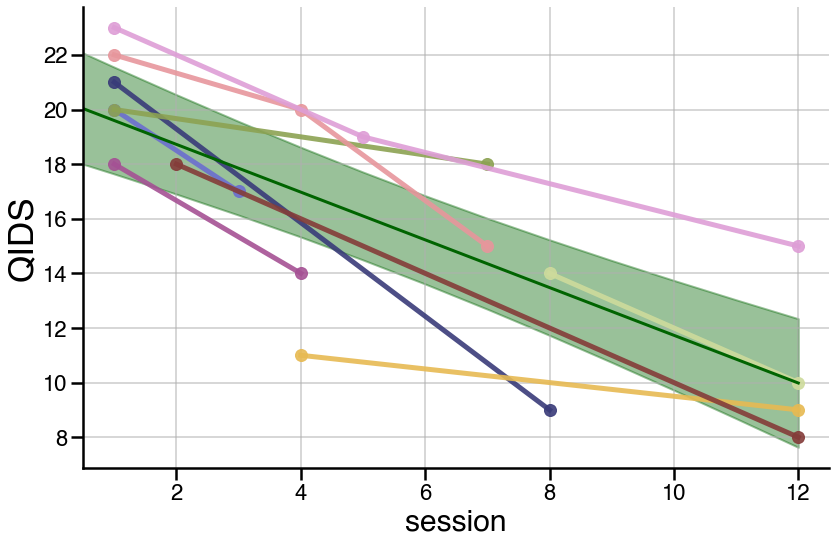

In [7]:
plot_feature_sessions(exp_df_mean, feature='QIDS', prepost='pre')
plt.plot(pred['sessions'], pred['pred'], color='darkgreen')
plt.fill_between(pred['sessions'], pred['LCB0.025'], pred['UCB0.975'], color='darkgreen', alpha=0.4)
despine()
plt.ylabel('QIDS', size=35)
plt.xlabel('session', size=30)
plt.grid(alpha=0.5)

### Statistics

In [8]:
pre_df_mean = exp_df_mean[exp_df_mean['preposts']=='Pre']

md = smf.mixedlm("QIDS ~ sessions", pre_df_mean, groups=pre_df_mean["patients"])
mdf = md.fit()
print(mdf.summary())
print(mdf.pvalues)

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: QIDS    
No. Observations: 20      Method:             REML    
No. Groups:       9       Scale:              4.1649  
Min. group size:  2       Log-Likelihood:     -47.1871
Max. group size:  3       Converged:          Yes     
Mean group size:  2.2                                 
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept   20.463    1.061 19.288 0.000 18.383 22.542
sessions    -0.873    0.127 -6.849 0.000 -1.123 -0.623
Group Var    4.000    1.835                           

Intercept    6.832489e-83
sessions     7.418852e-12
Group Var    2.854344e-01
dtype: float64


# 2. Acute Changes

## a. Aperiodic exponent

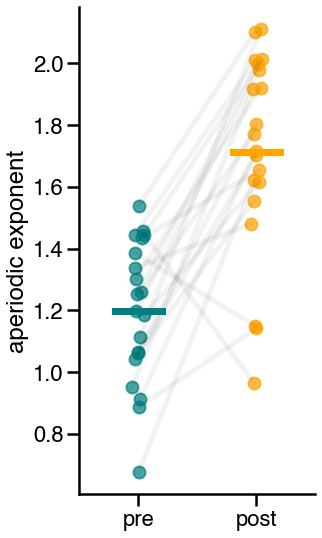

In [9]:
plot_feature_prepost(exp_df_mean, feature='chans_exps')
plt.ylabel('aperiodic exponent')
despine()

### Statistics

In [10]:
means_pre = exp_df_mean[exp_df_mean['preposts']=='Pre']['chans_exps'].values
means_post = exp_df_mean[exp_df_mean['preposts']=='Post']['chans_exps'].values

stats = ttest(means_pre, means_post, paired=True)
stats

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-5.988458,19,two-sided,0.000009,"[-0.69, -0.33]",1.814082,2374.758,1.0


In [11]:
print(ttest_rel(means_pre, means_post))

Ttest_relResult(statistic=-5.988457633889583, pvalue=9.202034509706227e-06)


## b. Delta band power

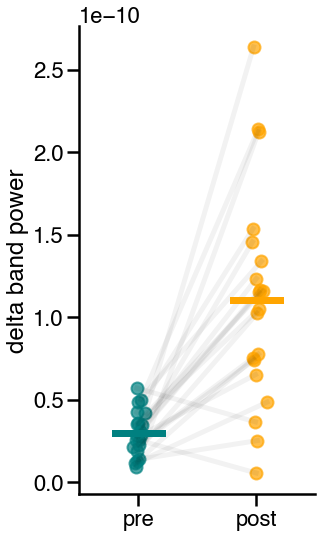

In [12]:
plot_feature_prepost(exp_df_mean, feature='delta_band_pow')
plt.ylabel('delta band power')
despine()

### Statistics

In [13]:
means_pre = exp_df_mean[exp_df_mean['preposts']=='Pre']['delta_band_pow'].values
means_post = exp_df_mean[exp_df_mean['preposts']=='Post']['delta_band_pow'].values

stats = ttest(means_pre, means_post, paired=True)
stats

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-5.733022,19,two-sided,0.000016,"[-0.0, -0.0]",1.703357,1448.744,1.0


In [14]:
print(ttest_rel(means_pre, means_post))

Ttest_relResult(statistic=-5.73302211962444, pvalue=1.5895565714226165e-05)


## c. Delta oscillation power

In [15]:
# filter patients with missing delta <<< turn this into a function?
delta_mean = pd.DataFrame(exp_df_mean[exp_df_mean['deltas'].notna()])
delt_df = pd.DataFrame(delta_mean.groupby(['patients', 'sessions'])['deltas'].count())# count delta values per session
delt_df_filt = delt_df[delt_df['deltas']>1] # exclude sessions with any missing delta
delt_locs = list(delt_df_filt.index) # get indices of groupby list (pat, ses)
delt_locs = [list(ele) for ele in delt_locs] # convert list of tuples to list of lists

# FIX THIS CODE TO MAKE SURE BEN IS EXCLUDED

delta_filt_mean = pd.DataFrame()

for ind, pat in enumerate(delt_locs):
    next_sub = delta_mean.loc[(delta_mean['patients'] == delt_locs[ind][0]) & (delta_mean['sessions'] == delt_locs[ind][1])]
    delta_filt_mean = pd.concat([delta_filt_mean, next_sub])


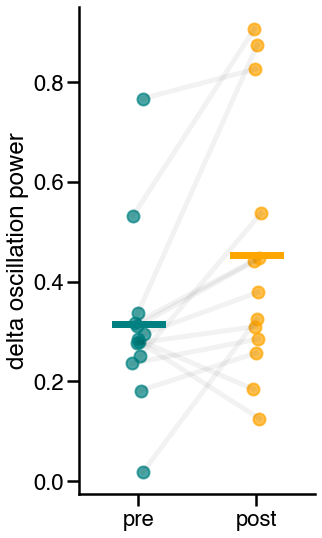

In [16]:
plot_feature_prepost(delta_filt_mean, feature='delta_pows')
plt.ylabel('delta oscillation power')
despine()

### Statistics

In [17]:
means_pre = delta_filt_mean[delta_filt_mean['preposts']=='Pre']['delta_pows'].values
means_post = delta_filt_mean[delta_filt_mean['preposts']=='Post']['delta_pows'].values

stats = ttest(means_pre, means_post, paired=True)
stats

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.622612,12,two-sided,0.022277,"[-0.26, -0.02]",0.62545,3.038,0.545092


In [18]:
print(ttest_rel(means_pre, means_post))

Ttest_relResult(statistic=-2.6226118523128443, pvalue=0.02227731341435222)


# 3. Longitudinal changes

## a. Aperiodic exponent

In [19]:
pred_exp = pd.read_csv('/Users/sydneysmith/Projects/ECT/NEW_ORGANIZATION/02-Data/AnalysisFeatures/exponent_model_predictions_exclude_NEW.csv')

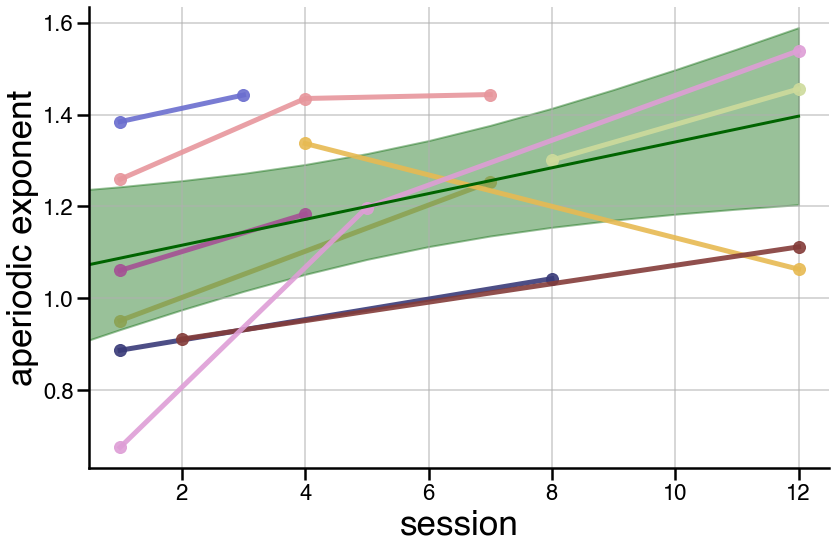

In [20]:
plot_feature_sessions(exp_df_mean, feature='chans_exps', prepost='pre')
plt.plot(pred_exp['sessions'], pred_exp['pred'], color='darkgreen')
plt.fill_between(pred_exp['sessions'], pred_exp['LCB0.025'], pred_exp['UCB0.975'], color='darkgreen', alpha=0.4)
despine()
plt.ylabel('aperiodic exponent', size=35)
plt.xlabel('session', size=35)
plt.grid(alpha=0.5)

### Statistics

In [21]:
md = smf.mixedlm("chans_exps ~ sessions", pre_df_mean, groups=pre_df_mean["patients"])
mdf = md.fit()
print(mdf.summary())
print(mdf.pvalues)

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: chans_exps
No. Observations: 20      Method:             REML      
No. Groups:       9       Scale:              0.0306    
Min. group size:  2       Log-Likelihood:     -1.8569   
Max. group size:  3       Converged:          Yes       
Mean group size:  2.2                                   
---------------------------------------------------------
           Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept  1.052     0.085  12.345  0.000   0.885   1.218
sessions   0.027     0.011   2.370  0.018   0.005   0.048
Group Var  0.019     0.128                               

Intercept    5.199960e-35
sessions     1.779014e-02
Group Var    4.068153e-01
dtype: float64


## b. Delta band power

In [22]:
pred_delt = pd.read_csv('/Users/sydneysmith/Projects/ECT/NEW_ORGANIZATION/02-Data/AnalysisFeatures/delta_model_predictions_exclude_NEW.csv')

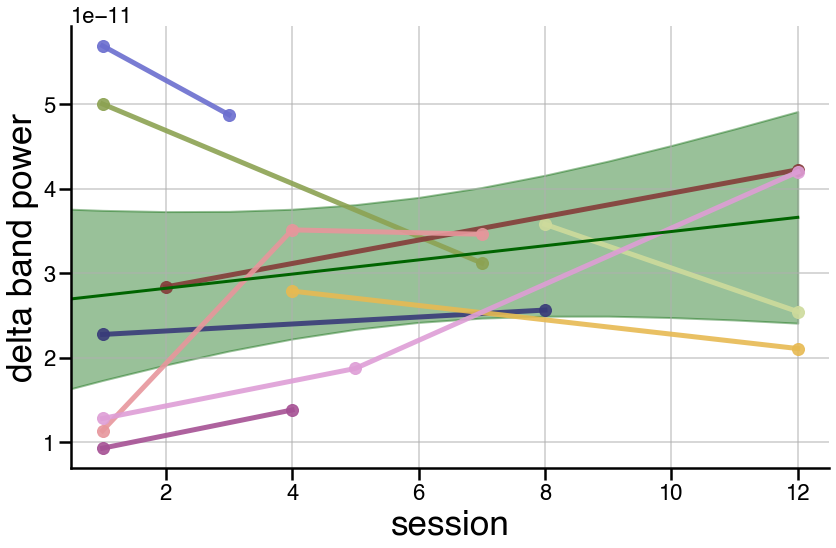

In [23]:
plot_feature_sessions(exp_df_mean, feature='delta_band_pow', prepost='pre')
plt.plot(pred_delt['sessions'], pred_delt['pred'], color='darkgreen')
plt.fill_between(pred_delt['sessions'], pred_delt['LCB0.025'], pred_delt['UCB0.975'], color='darkgreen', alpha=0.4)
despine()
plt.ylabel('delta band power', size=35)
plt.xlabel('session', size=35)
plt.grid(alpha=0.5)

### Statistics

In [24]:
md = smf.mixedlm("delta_band_pow ~ sessions", pre_df_mean, groups=pre_df_mean["patients"])
mdf = md.fit()
print(mdf.summary())
print(mdf.pvalues)

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: delta_band_pow
No. Observations: 20      Method:             REML          
No. Groups:       9       Scale:              0.0000        
Min. group size:  2       Log-Likelihood:     421.2339      
Max. group size:  3       Converged:          Yes           
Mean group size:  2.2                                       
--------------------------------------------------------------
            Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
--------------------------------------------------------------
Intercept   0.000      0.000   4.937   0.000    0.000    0.000
sessions    0.000      0.000   1.106   0.269   -0.000    0.000
Group Var   0.000      0.000                                  

Intercept    7.920662e-07
sessions     2.686950e-01
Group Var    3.502810e-01
dtype: float64


/Users/sydneysmith/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


## c. Correlation of LME slopes of QIDS improvement and change in exponent

In [26]:
slopes_df = pd.read_csv('/Users/sydneysmith/Projects/ECT/NEW_ORGANIZATION/02-Data/AnalysisFeatures/LME_pre_slopes_exclude_NEW.csv')
#slopes_df = pd.read_csv('/Users/sydneysmith/Projects/ECT/NEW_ORGANIZATION/02-Data/AnalysisFeatures/LME_pre_slopes_NEW.csv')

/Users/sydneysmith/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


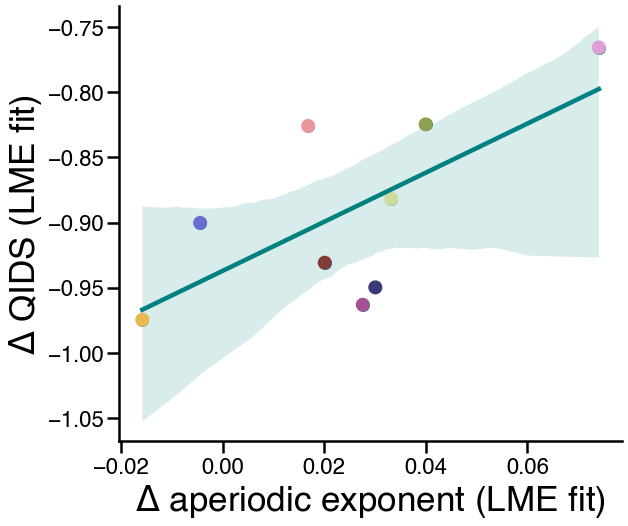

In [27]:
pats = np.unique(slopes_df['patients'])
colors = plt.cm.tab20b(np.linspace(0,1,len(pats)))

plt.figure(figsize=[9,8])
sns.regplot(slopes_df['chans_exps'], slopes_df['QIDS'], color='teal')
plt.scatter(slopes_df['chans_exps'], slopes_df['QIDS'], color=colors)
plt.xlabel('$\Delta$ aperiodic exponent (LME fit)', size=35);
plt.ylabel('$\Delta$ QIDS (LME fit)', size=35)

sns.despine()

In [28]:
print(pairwise_corr(slopes_df, columns=['chans_exps', 'QIDS']))
print(pearsonr(slopes_df['chans_exps'], slopes_df['QIDS']))

            X     Y   method alternative  n         r         CI95%     p-unc  \
0  chans_exps  QIDS  pearson   two-sided  9  0.674568  [0.02, 0.92]  0.046251   

  BF10     power  
0  2.3  0.555572  
(0.6745681983670493, 0.046251464372285556)


/Users/sydneysmith/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


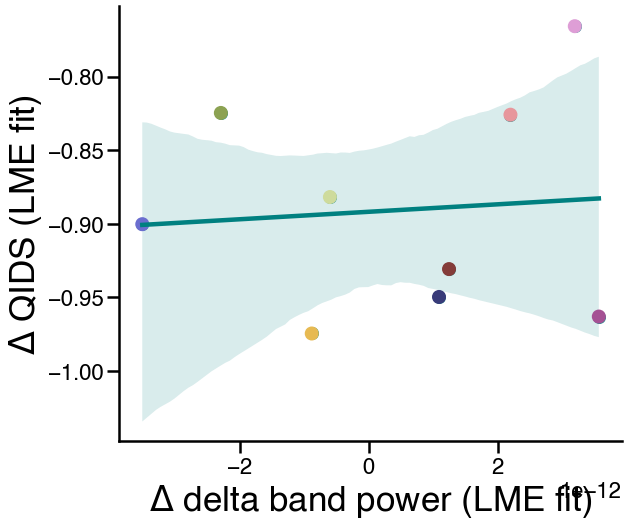

In [29]:
pats = np.unique(slopes_df['patients'])
colors = plt.cm.tab20b(np.linspace(0,1,len(pats)))

plt.figure(figsize=[9,8])
sns.regplot(slopes_df['delta_band_pow'], slopes_df['QIDS'], color='teal')
plt.scatter(slopes_df['delta_band_pow'], slopes_df['QIDS'], color=colors)
plt.xlabel('$\Delta$ delta band power (LME fit)', size=35);
plt.ylabel('$\Delta$ QIDS (LME fit)', size=35)

sns.despine()

In [30]:
print(pairwise_corr(slopes_df, columns=['delta_band_pow', 'QIDS']))
print(pearsonr(slopes_df['delta_band_pow'], slopes_df['QIDS']))

                X     Y   method alternative  n         r          CI95%  \
0  delta_band_pow  QIDS  pearson   two-sided  9  0.085641  [-0.61, 0.71]   

      p-unc   BF10     power  
0  0.826596  0.415  0.054505  
(0.08564127179314163, 0.8265958634410017)


# 4. Power Spectra

## a. Acute Spectra

In [31]:
signal_path = os.path.dirname('/Users/sydneysmith/Projects/ECT/NEW_ORGANIZATION/02-Data/NEW_RawFIF/')

In [32]:
avg_preSpec, avg_postSpec = get_avg_spectra_fits(signal_path, exclude_XXX)

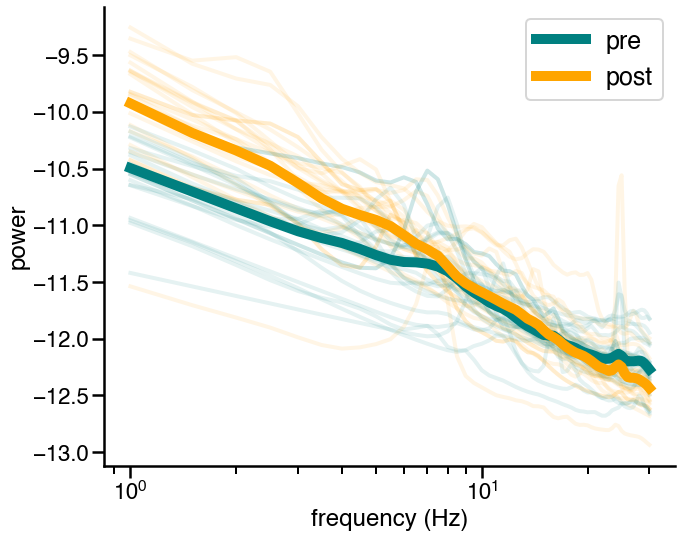

In [33]:
plot_spectra(avg_preSpec, avg_postSpec, loglog=True)

## b. Longitudinal Spectra (for one example patient)

In [34]:
# plot spectra for patient YYY

spectra = dict(np.load('/Users/sydneysmith/Projects/ECT/NEW_ORGANIZATION/02-Data/spectra.npz'))

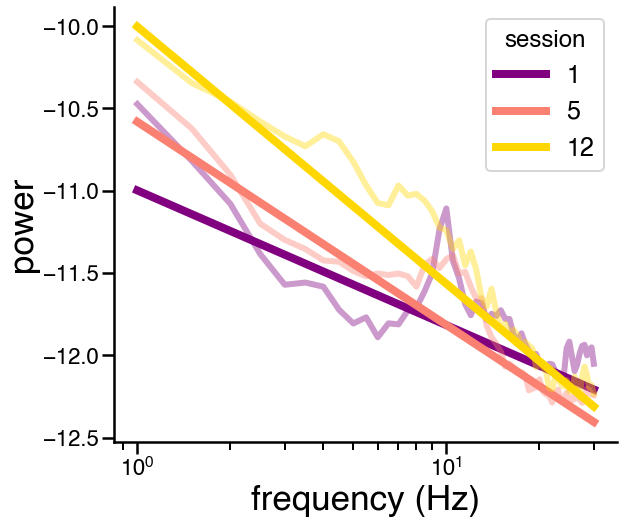

In [35]:
yyy_sessions = [1,5,12]
colors = ['purple', 'salmon', 'gold']
fm = FOOOF(peak_threshold=1.5, peak_width_limits=[1.00,12.0], aperiodic_mode='fixed')

plt.figure(figsize=[9,8])

for i, session in enumerate(yyy_sessions):
    
    inds = np.where((spectra['patient']=='YYY') & (spectra['prepost']=='Pre') & (spectra['session']==session))
    session_spectra = spectra['spectra'][inds]
    avg_session_spectrum = np.mean(session_spectra, axis=0)
    log_spec = np.log10(avg_session_spectrum)
    freqs = np.linspace(1,30,59)
    
    fm.fit(freqs, avg_session_spectrum, freq_range=[1,30])
    psd = fm.fooofed_spectrum_
    offset = fm.aperiodic_params_[0]
    exponent = fm.aperiodic_params_[1]
    adj_psd = psd - offset
    
    plt.plot(freqs, log_spec, color=colors[i], lw=6, alpha=0.4) # rawdat
    plt.plot(freqs, fm._ap_fit, color=colors[i], label=str(session), lw=8) # aper fits
    

plt.legend(prop={'size': 25}, title='session')
plt.xscale('log')
plt.xlabel('frequency (Hz)', size=35)
plt.ylabel('power', size=35)
sns.despine()
    